In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns

%matplotlib inline

# Introduction

The Mall customers dataset contains information about people visiting the mall. The dataset has gender, customer id, age, annual income, and spending score. It collects insights from the data and group customers based on their behaviors.

Segment the customers based on the age, gender, interest. Customer segmentation is an important practise of dividing customers base into individual groups that are similar. It is useful in customised marketing.

we will focus on clustering models in this data set 

# clustering

# data exploration

In [3]:
data=pd.read_csv(r'C:\Users\Admin\Desktop\ML\IBM\Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data=data.drop(['CustomerID'],axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


as we see we have no missing values

In [6]:
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [7]:
data.shape

(200, 4)

In [8]:
data['Gender'].replace(to_replace=['Male','Female'], value=[0,1],inplace=True)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


replacing male and female with one and zero

In [9]:
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


for feature engineering i changed male and feamle to 0 and 1 and removed customer id and saw the correlation of data and skewed values 

In [10]:
for col in data.columns:
    data[col] = data[col].astype(np.float)

In [11]:
corr_mat=data.corr()
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Gender,0.000000,-0.060867,-0.056410,0.058109
Age,-0.060867,0.000000,-0.012398,-0.327227
Annual Income (k$),-0.056410,-0.012398,0.000000,0.009903
Spending Score (1-100),0.058109,-0.327227,0.009903,0.000000


In [12]:
corr_mat.abs().idxmax()

Gender                                       Age
Age                       Spending Score (1-100)
Annual Income (k$)                        Gender
Spending Score (1-100)                       Age
dtype: object

In [13]:
log_columns = data.skew().sort_values(ascending=False)
log_columns

Age                       0.485569
Annual Income (k$)        0.321843
Spending Score (1-100)   -0.047220
Gender                   -0.243578
dtype: float64

In [14]:
for col in log_columns.index:
    data[col] = np.log1p(data[col])

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[[col]]).squeeze()

scaled and skewed our data

# kmeans

In [16]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2)
km=km.fit(data)

data['kmeans']=km.predict(data)

In [38]:
km_list = list()


for clust in range(1,21):
    km = KMeans(n_clusters=clust)
    km = km.fit(data)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

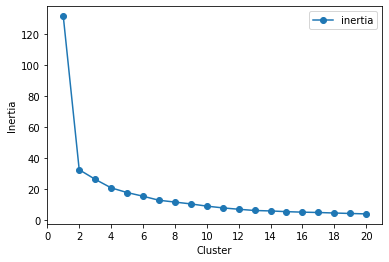

In [18]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

depending on what kind of model we what we can choose between 2,3 clusters

# ward

In [33]:
from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data)
data['agglom'] = ag.fit_predict(data)

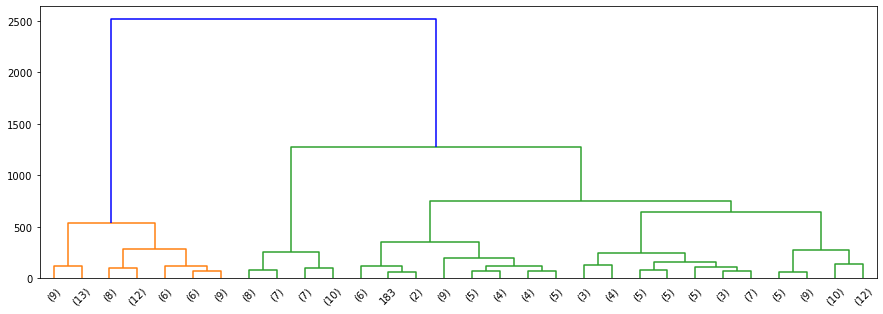

In [37]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='blue')

# DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

db=DBSCAN(eps=0.3, min_samples=10)
db=db.fit(data)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [21]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


we see again that 2 clusters is good

# MeanShift

In [22]:
from sklearn.cluster import MeanShift,estimate_bandwidth


bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 2


# summarry of what i did

so i used kmeans and dbscan and mean shit and  AgglomerativeClustering and saw that i got the same number of clusters in all the model(2) 

# Summary Key Findings and Insights
on this dataset i examined 4 clustering models and saw that they both perfomred the same, models gave the same result but if the dataset is more complex then we have to choose the best model


# part 2
# Dimensionality Reduction 
i used credit card data set to see if i can implement Dimensionality Reduction
dataset has 30 columns including v1 till v28 and theres a class column

In [23]:
df=pd.read_csv(r'C:\Users\Admin\Desktop\ML\IBM\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [26]:
X=df.drop(['Class'],axis=1)
y=df['Class']

In [27]:
corr_mat = X.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
corr_mat

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,0.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596
V1,0.117396,0.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,...,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709
V2,-0.010593,4.697350e-17,0.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,...,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409
V3,-0.419618,-1.424390e-15,2.512175e-16,0.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,...,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,0.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,...,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732
V5,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,0.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,...,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356
V6,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,0.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,...,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981
V7,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,0.000000e+00,-8.691834e-17,7.933251e-16,...,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311
V8,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,0.000000e+00,2.900829e-16,...,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079
V9,-0.008660,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,0.000000e+00,...,-4.340941e-16,4.578389e-17,2.871855e-17,5.929286e-16,-2.346385e-16,1.099645e-15,-1.388725e-15,-2.287414e-16,9.146779e-16,-0.044246


In [28]:
corr_mat.abs().idxmax()

Time          V3
V1        Amount
V2        Amount
V3          Time
V4          Time
V5        Amount
V6        Amount
V7        Amount
V8        Amount
V9        Amount
V10       Amount
V11         Time
V12         Time
V13         Time
V14         Time
V15         Time
V16         Time
V17         Time
V18         Time
V19       Amount
V20       Amount
V21       Amount
V22         Time
V23       Amount
V24         Time
V25         Time
V26         Time
V27       Amount
V28       Amount
Amount        V2
dtype: object

In [29]:
log_columns = data.skew().sort_values(ascending=False)

log_columns

Age                      -0.089491
agglom                   -0.243578
kmeans                   -0.243578
Gender                   -0.243578
Annual Income (k$)       -0.735997
Spending Score (1-100)   -1.565605
dtype: float64

In [30]:
for col in log_columns.index:
    data[col] = np.log1p(data[col])
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[[col]]).squeeze()

In [31]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

for n in range(1, 6):
    
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X)
    
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': X.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.999972
2,PCA(n_components=2),1
3,PCA(n_components=3),1
4,PCA(n_components=4),1
5,PCA(n_components=5),1


In [32]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X
        
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    return -1.0 * mse

param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}

kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(data)

kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=1.0, kernel='rbf', n_components=2)

we can use pca with n=2 as our model

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X=df.drop(['Class'],axis=1)
y=df['Class']
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)


def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(solver='liblinear'))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [5,10,15,20,25,30]
score_list = [get_avg_score(n) for n in ns]

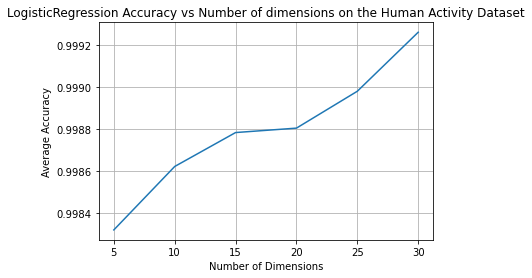

In [46]:
ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)

here we see how usung pca effects Logistic Regression and how it can help us getting better accuracy